# How to detrend TESS Noise at the pixel level

Sometimes in TESS data we need to detrend at the pixel level, not the light curve level. This is particularly helpful in crowded regions. Detrending at the pixel level means correcting each pixel time series individually, rather than the summed time series. We should remember this is a trade off; detrending at the pixel level will make our final light curve noisier, and will also make us more vulnerable to overfitting.

In this example, we're going to rely heavily on `lightkurve`'s `Corrector` API, which uses `DesignMatrix` objects to correct data. You can read more about the API [here](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.html) and go through the [tutorials](https://docs.lightkurve.org/tutorials/index.html) as a good way to get started. 

Let's take a look at one way to detrend at the pixel level.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn-white')

First, let's get some data from TESS survey. Here is a nice TOI which has an exoplanet and significant stellar variability. I've cut this out of the TESS FFIs using MAST's TESSCut tool. We create an aperture mask that includes our target, but we're going to make sure we have lots of pixels around the target to use for detrending.

In [2]:
tpf = lk.search_tesscut('TOI-2076')[0].download(cutout_size=(30, 31))
aperture_mask = tpf.create_threshold_mask(10)

<AxesSubplot:title={'center':'Target ID: TOI-2076, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

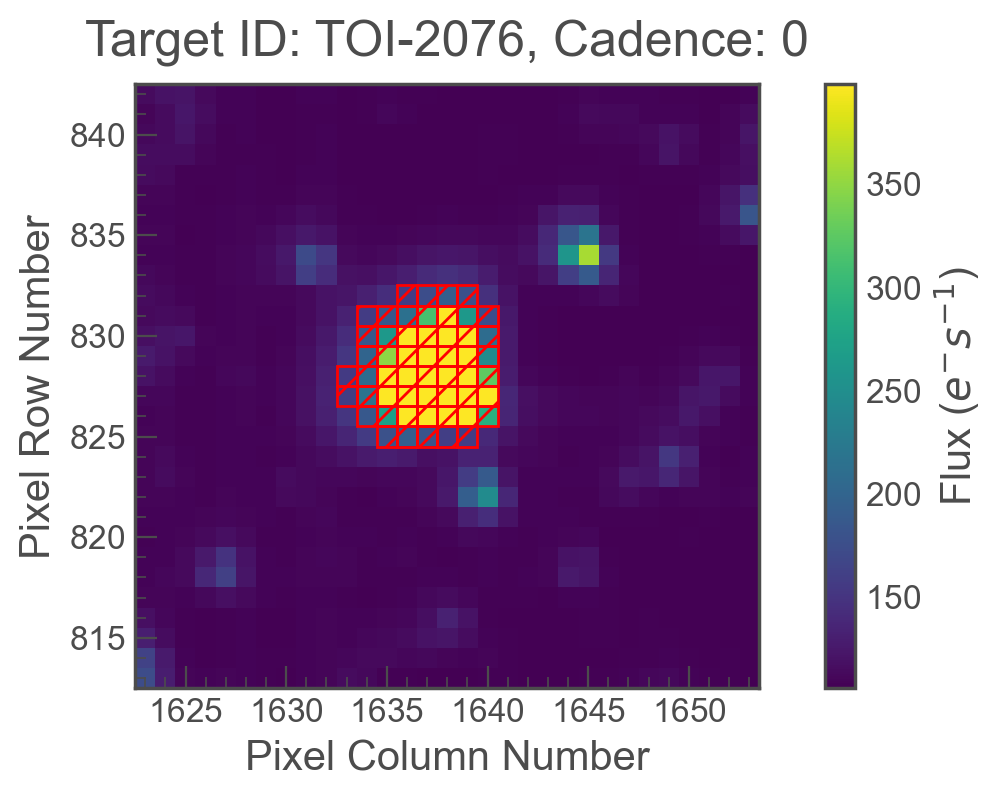

In [3]:
tpf.plot(aperture_mask=aperture_mask)

# Step 1: Obtain some vectors of trends are in the data.

In order to detrend this data, we will need to identify trends we'd like to remove from the data. These might include:

- Time averages of pixels which capture the "average" scattered light
- Principal Components of pixels which capture common trends in the pixel light curves
- Cotrending Basis Vectors from the mission
- Simple astrophysics models.

We're going to see how to make these below, and in this case we'll make these into `lightkurve.DesignMatrix` objects, so we can use them to correct the data. You can read more about that in the [docs](https://docs.lightkurve.org/reference/api/lightkurve.correctors.RegressionCorrector.html) for `lightkurve`.

## Time Averaged Pixel Light Curve

Below we create the time averaged pixel light curve, using only pixels that are "faint". This lets us capture the TESS Scattered light.

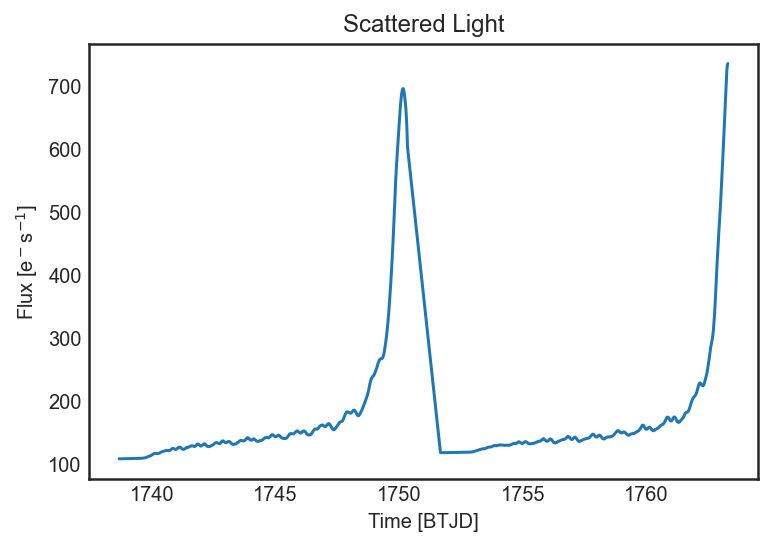

In [4]:
# Time average of the pixels in the TPF:
max_frame = tpf.flux.value.max(axis=0)
# This renormalizes any columns which are bright because of straps on the detector
max_frame -= np.median(max_frame, axis=0)
# This aperture is any "faint" pixels:
bkg_aper = max_frame < np.percentile(max_frame, 30)
# The average light curve of the faint pixels is a good estimate of the scattered light
scattered_light = tpf.flux.value[:, bkg_aper].mean(axis=1)

fig, ax = plt.subplots()
ax.plot(tpf.time.value, scattered_light)
ax.set(title='Scattered Light', xlabel='Time [BTJD]', ylabel='Flux [e$^-$s$^{-1}$]');

Removing this trend is very simple, as shown below. But this is one component, we'd probably be better using something more sophisticated like...

## Principal Components of the data

We can use our background aperture to create pixel time series and then take Principal Components of the data using Singular Value Decomposition. This gives us the "top" trends that are present in the background data.

Here we will use lightkurve to take PCA of the background aperture from above.

In [5]:
bkg_aper.sum()

279

We use the background aperture to get the pixel time series of the data. This has shape ntimes, by npixels:

In [6]:
tpf.flux.value[:, bkg_aper].shape

(1118, 279)

In [7]:
pca_dm = lk.DesignMatrix(tpf.flux.value[:, bkg_aper], name='PCA').pca(3)

We use 3 components, but you could use more or less depending on how many background pixels you have! How many components should you use? It depends on your dataset. A good rule of thumb would be to use many fewer components than there are pixels. Here, we're using ~100x fewer components than there are pixels.

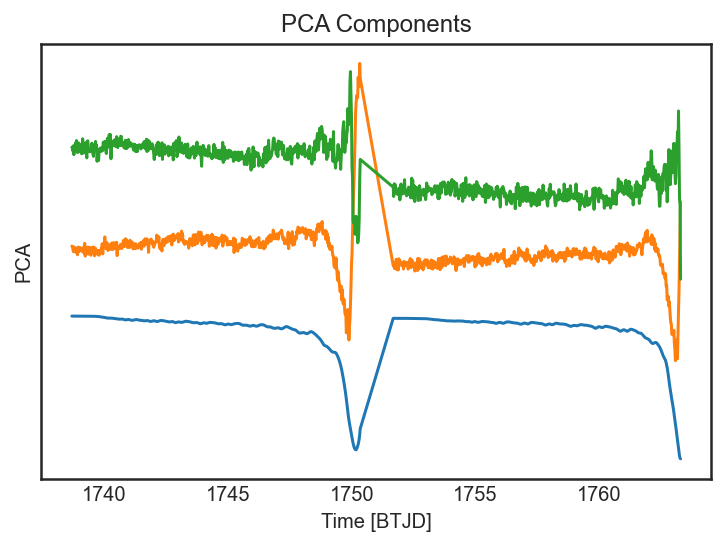

In [8]:
# Time average of the pixels in the TPF:
fig, ax = plt.subplots()
ax.plot(tpf.time.value, pca_dm.X + np.arange(pca_dm.shape[1]) * 0.1)
ax.set(title='PCA Components', xlabel='Time [BTJD]', ylabel='PCA', yticks=[]);

We're going to build some more components to detrend, and then we'll see how to use them in step 2.

## Using the mission Cotrending Basis Vectors

The TESS mission pipeline provides cotrending basis vectors (CBVs) which capture common trends in the dataset. We can use these to detrend out pixel level data. 

The mission provides `MultiScale` CBVs, which are at different time scales. In this case, we don't want to use the long scale CBVs, because this may fit out real astrophysical variability. Instead we will use the medium and short time scale CBVs.

In [10]:
# This let's us get access to the CBVs from the mission. This might take a while to download depending on your internet connection.
# `band` is used to specify the timescale of the CBVs
cbvs_1 = lk.correctors.cbvcorrector.load_tess_cbvs(sector=tpf.sector, camera=tpf.camera, ccd=tpf.ccd, cbv_type='MultiScale', band=2).interpolate(tpf.to_lightcurve())
cbvs_2 = lk.correctors.cbvcorrector.load_tess_cbvs(sector=tpf.sector, camera=tpf.camera, ccd=tpf.ccd, cbv_type='MultiScale', band=3).interpolate(tpf.to_lightcurve())

# This converts the CBVs into a `designmatrix` object for us to use later.
# You can change `indices` to tune the number of CBVs to use.
cbv_dm1 = cbvs_1.to_designmatrix(cbv_indices=np.arange(1, 8))
cbv_dm2 = cbvs_2.to_designmatrix(cbv_indices=np.arange(1, 8))

# This combines the different timescale CBVs into a single `designmatrix` object
cbv_dm = lk.DesignMatrixCollection([cbv_dm1, cbv_dm2]).to_designmatrix()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


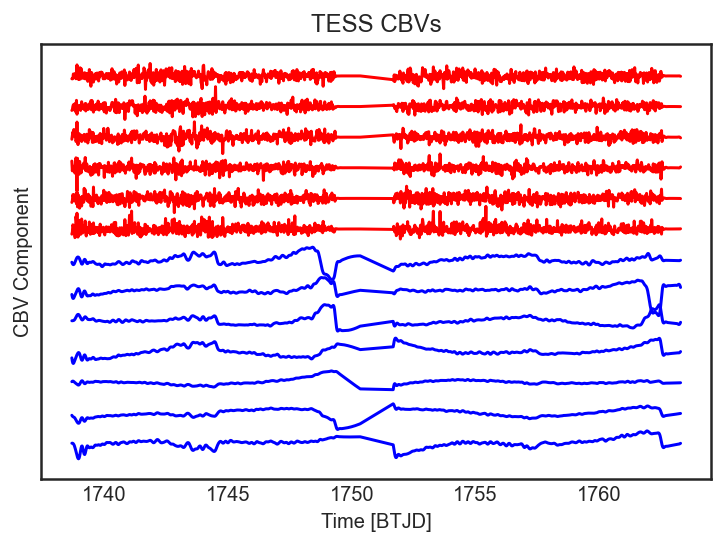

In [11]:
# Below we plot the two scales of CBVs
fig, ax = plt.subplots()
ax.plot(tpf.time.value, cbv_dm1.X + np.arange(cbv_dm1.shape[1]) * 0.05, c='b')
ax.plot(tpf.time.value, cbv_dm2.X + (np.arange(cbv_dm2.shape[1]) + cbv_dm1.shape[1]) * 0.05, c='r')
ax.set(title='TESS CBVs', xlabel='Time [BTJD]', ylabel='CBV Component', yticks=[]);
plt.legend()

## A simple model for astrophysics

We could assume when detrending the pixels time series that all the pixels have no astrophysical variability, and fit just a systematics model. However, we know this is not true. 

In this detrending, we want to *allow* for a simple astrophysics model while fitting our systematics model. This means that if, for example, there is a pixel with significant astrophysical variability from stellar rotation, we can still fit the systematics "around" that variability. 

We can make a simple basis-spline (b-spline) model for astrophysical variability to help us capture that. This will be a flexible, smooth model. 

The spline model is parameterized by either a number of knots, or points at which to put knots. You can see below an example of a spline with 10 components with evenly spaced knots in time.

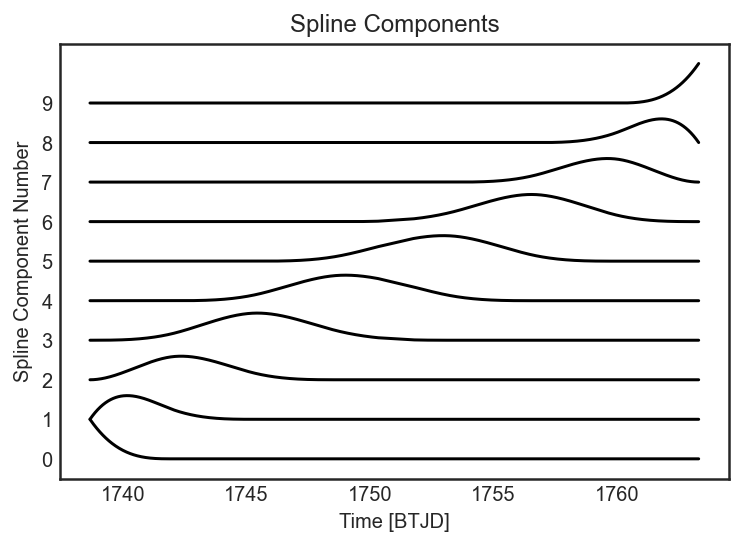

In [12]:
spline_dm = lk.designmatrix.create_spline_matrix(tpf.time.value, n_knots=10)

# Time average of the pixels in the TPF:
fig, ax = plt.subplots()
ax.plot(tpf.time.value, spline_dm.X + np.arange(spline_dm.shape[1]), c='k')
ax.set(title='Spline Components', xlabel='Time [BTJD]', ylabel='Spline Component Number', yticks=np.arange(10));

Dotting this spline design matrix with some values makes a smooth time series, below are some examples of the spline matrix dotted with random weights.

Text(0.5, 0, 'Time')

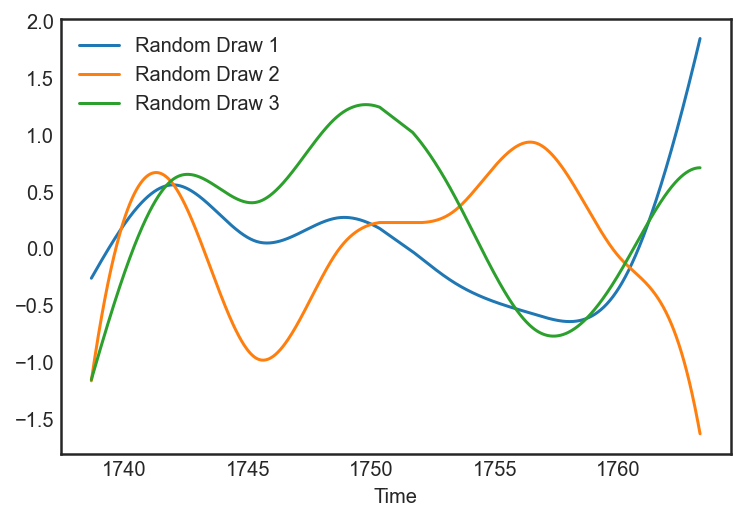

In [13]:
plt.plot(tpf.time.value, spline_dm.X.dot(np.random.normal(size=spline_dm.shape[1])), label='Random Draw 1')
plt.plot(tpf.time.value, spline_dm.X.dot(np.random.normal(size=spline_dm.shape[1])), label='Random Draw 2')
plt.plot(tpf.time.value, spline_dm.X.dot(np.random.normal(size=spline_dm.shape[1])), label='Random Draw 3')
plt.legend()
plt.xlabel("Time")

For our purposes, we probably want to capture variability on the timescale of ~1 day, so we'll use 30 knots.

In [14]:
spline_dm = lk.designmatrix.create_spline_matrix(tpf.time.value, n_knots=30)

# Step 2: Detrending the data

Now we have some vectors to detrend against the design matrices we've built. To do this we'll first make a `collection` of the design matrices above. Note in the example below, I'm using the average faint pixel time series `scattered_light` from above. You can use the PCA components, but this might overfit some of the astrophysical time variability in some cases. It's worth experimenting and using your best judgement.

In [15]:
dm = lk.DesignMatrixCollection([lk.DesignMatrix(scattered_light, name='scattered_light'), 
                               cbv_dm,
                               spline_dm,
                               ])
dm

DesignMatrixCollection:
	scattered_light DesignMatrix (1118, 1)
	CBVs DesignMatrix (1118, 13)
	spline DesignMatrix (1118, 30)

Now we're going to detrend each pixel time series. We *can* use `lightkurve` for this, although it's not designed to do so (yet!) At the bottom of this notebook is some clearer instructions for doing this fit without using `lightkurve.RegressionCorrector` (making it faster, but harder to read the code easily). 

In [16]:
# Blank arrays
full_model, systematics_model = np.ones((2, *tpf.shape))
for idx in tqdm(range(tpf.shape[1])):
    for jdx in range(tpf.shape[2]):
        pixel_lightcurve = lk.LightCurve(time=tpf.time.value, flux=tpf.flux.value[:, idx, jdx], flux_err=tpf.flux_err.value[:, idx, jdx])
        r = lk.RegressionCorrector(pixel_lightcurve)
        # Correct the pixel light curve by our design matrix
        r.correct(dm)
        # Extract just the systematics components
        systematics_model[:, idx, jdx] = (r.diagnostic_lightcurves['scattered_light'].flux.value +
                                          r.diagnostic_lightcurves['CBVs'].flux.value)
        # Add all the components
        full_model[:, idx, jdx] =  (r.diagnostic_lightcurves['scattered_light'].flux.value +
                                    r.diagnostic_lightcurves['CBVs'].flux.value +
                                    r.diagnostic_lightcurves['spline'].flux.value)


100%|███████████████████████████████████████████| 30/30 [00:38<00:00,  1.27s/it]


# Step 3: Looking at the results

We can plot the results of our model to check that it's behaving as we expect. First let's look at the light curve:

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

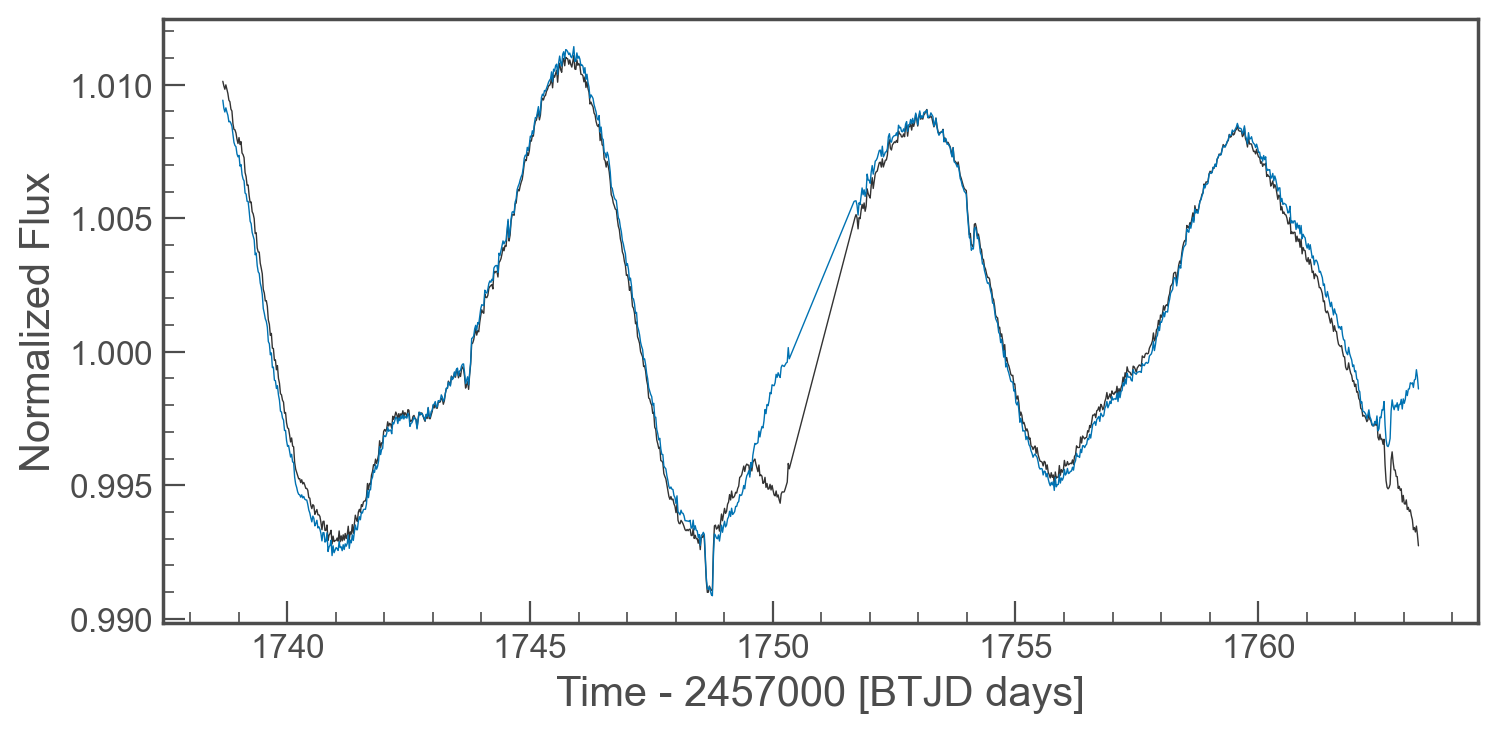

In [17]:
ax = (tpf - scattered_light[:, None, None]).to_lightcurve(aperture_mask=aperture_mask).normalize().plot()
(tpf - systematics_model).to_lightcurve(aperture_mask=aperture_mask).normalize().plot(ax=ax)

This looks good, the scattered light is largly removed, the jitter has improved, and the astrophysical variability is still present. 

Now we can look at the residuals between the data, and our best fit model of the scene at the pixel level.

The first "rough" model is simply the `scattered_light` model (time average of faint pixels) plus the "mean" TPF image. This is our best guess at the model, assuming no systematics, and no astrophysics.

In [18]:
rough_model = scattered_light[:, None, None] + (tpf.flux.value - scattered_light[:, None, None]).mean(axis=0)

In [19]:
(tpf - rough_model)[:100].animate(vmin=-10, vmax=10, cmap='coolwarm')

This looks fairly poor, we can see significant systematics from the TESS straps, and the sources on the detector.

Next we'll look at our full pixel model. This model accounts for systematics in each pixel, so the only thing left should be the changing astrophysics (stellar variability, exoplanet transits, etc). 

In [20]:
(tpf - full_model)[:100].animate(vmin=-10, vmax=10, cmap='coolwarm')

This looks much better, the significant residuals are only around our target, which we know to be variable.

# Closing Thoughts

Here are some quick thoughts about the model we've built:

1. We're not accounting for pixel to pixel correlation...

We could build a better model that would account for pixel to pixel correlation, and account for our understanding of the PRF, and our knowledge of the scene. But, such a model wouldn't be simple, or fast, so it's a trade off.

2. We could add in different detrenders.

Here we use a pretty good subset of reasonable detrenders capturing our beliefs about the systematics in the data. But, you may find other detrenders you want to use. You can add those into the design matrix above, and try them out.

3. We could be overfitting

This is a problem. **If your astrophysics looks like your systematics, you will fit out your astrophysics.** If you have an expected astronomical signal that looks like the TESS noise (e.g. perhaps a supernova during significant TESS scattered light) you will want to use a different approach. If you are interested in variability on a 14 day or greater period, you may want to use a different approach, since TESS data is observed in 14 day orbits. You could aid this slightly by adding *priors* to the fit, but you should read the `lightkurve` documentation on how to do that. In the above example, we don't have any priors on the weights of each component in the model fit. 

# Appendix: What is `lightkurve` doing under the hood?

The `lightkurve` `DesignMatrix` and `RegressionCorrector` API are really handy for handling the linear algebra and matrix shapes for doing this detrending, while still being fairly transparant. If you'd like to see an approximate example of what `lightkurve` is doing under the hood, see below. Pro tip: If you are comfortable with working this way, the code below is faster than using the `RegressionCorrector` because there are no overheads in making the `lightkurve` objects.

In [21]:
dm

DesignMatrixCollection:
	scattered_light DesignMatrix (1118, 1)
	CBVs DesignMatrix (1118, 13)
	spline DesignMatrix (1118, 30)

This design matrix object holds a matrix for us:

In [22]:
dm.X

array([[ 1.07706749e+02,  7.97148840e-05, -4.23769046e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.07661934e+02,  1.88647728e-04, -5.54770057e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.07693489e+02, -8.59174693e-05, -6.37903704e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 7.23289124e+02, -9.96930273e-04, -1.53576597e-03, ...,
         3.40531498e-03,  1.34770963e-01,  8.61804863e-01],
       [ 7.32467346e+02, -5.72606705e-04, -1.38454043e-03, ...,
         8.61783472e-04,  6.98443582e-02,  9.29291511e-01],
       [ 7.35253113e+02,  1.56082252e-06, -1.22108138e-03, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

In [23]:
# This tells us the index up to which the components are "systematics" and after which are "astrophysics"
dm_index = dm.to_designmatrix().shape[1] - spline_dm.shape[1]
# Blank arrays
full_model, systematics_model = np.ones((2, *tpf.shape))
# Iterate over all pixels
for idx in range(tpf.shape[1]):
    for jdx in range(tpf.shape[2]):
        # Get the flux and flux errors for the pixel
        y, ye = tpf.flux.value[:, idx, jdx], tpf.flux_err.value[:, idx, jdx]
        # Linear algebra
        sigma_w_inv = dm.X.T.dot(dm.X/ye[:, None]**2)
        B = dm.X.T.dot(y/ye**2)
        # Best fitting weights
        w = np.linalg.solve(sigma_w_inv, B)
        
        # Model for each pixel
        full_model[:, idx, jdx] = dm.X.dot(w)
        
        # Systematics only model
        systematics_model[:, idx, jdx] = dm.X[:, :dm_index].dot(w[:dm_index])

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

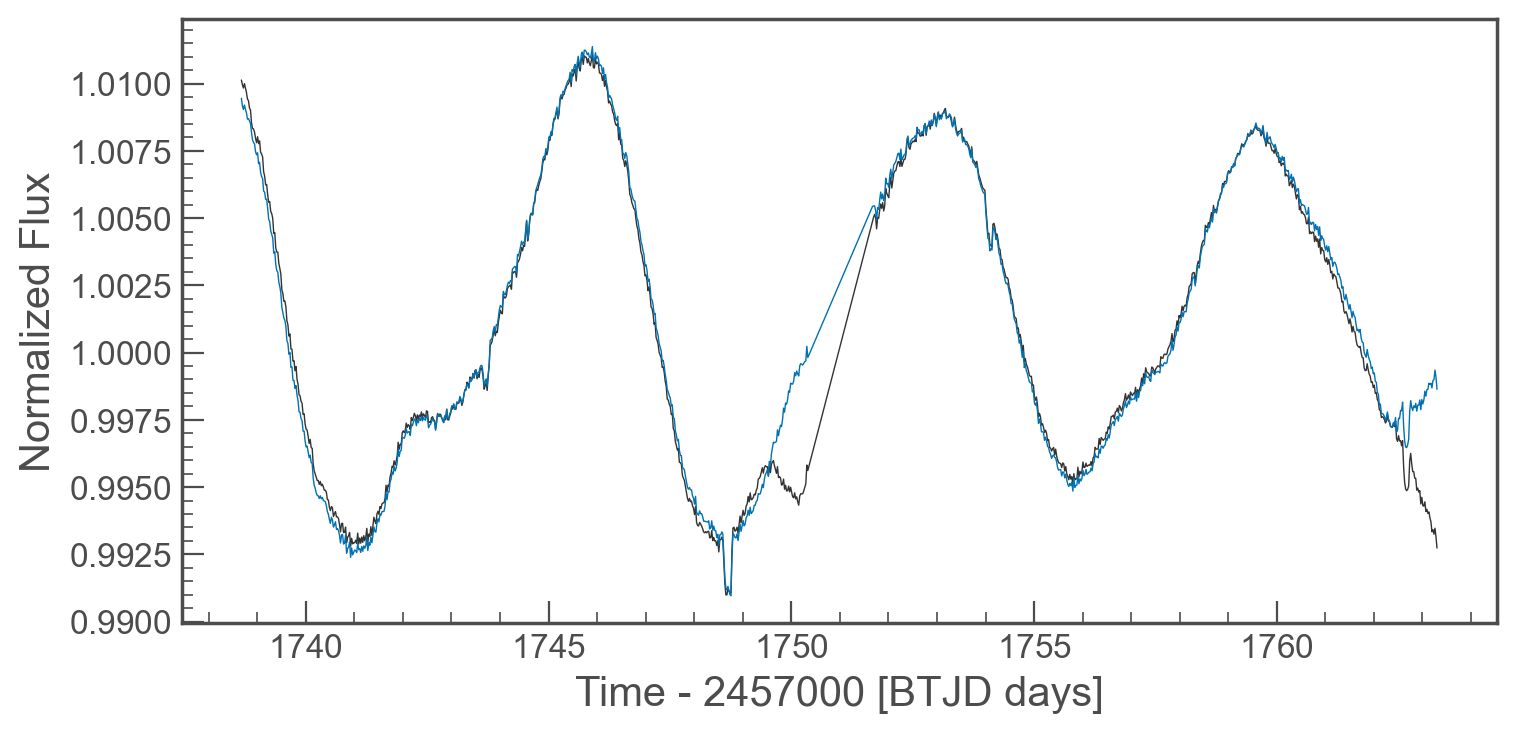

In [24]:
ax = (tpf - scattered_light[:, None, None]).to_lightcurve(aperture_mask=aperture_mask).normalize().plot()
(tpf - systematics_model).to_lightcurve(aperture_mask=aperture_mask).normalize().plot(ax=ax)